In [24]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
import itertools
import sys
sys.path.insert(0, '..')
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 16
import numpy as np
import pandas as pd
import requests
import seaborn as sns

import covid19

## data

In [60]:
deaths_path = 'time_series_covid19_deaths_US.csv'
deaths_path = covid19.data.download('deaths', repo='usa')
confirmed_path = 'time_series_covid19_deaths_US.csv'
confirmed_path = covid19.data.download('confirmed', repo='usa')
deaths_path, confirmed_path

('time_series_covid19_deaths_US.csv', 'time_series_covid19_confirmed_US.csv')

In [61]:
ds_counties = covid19.data.read_jhu_usa(deaths_path)
ds_counties['confirmed'] = covid19.data.read_jhu_usa(confirmed_path)['confirmed']
ds_counties['mortality'] = ds_counties['deaths'] / ds_counties['population'] * 100_000
ds_counties['daily_deaths'] = ds_counties['deaths'].diff('time')
ds_counties['daily_mortality'] = ds_counties['daily_deaths'] / ds_counties['population'] * 100_000
ds_counties['daily_confirmed'] = ds_counties['confirmed'].diff('time')

ds_counties = ds_counties.fillna(0)
ds_counties

<xarray.Dataset>
Dimensions:          (location: 3261, time: 140)
Coordinates:
  * time             (time) datetime64[ns] 2020-01-22 2020-01-23 ... 2020-06-09
  * location         (location) object 'US / American Samoa / ' ... 'US / Utah / Weber-Morgan'
    state_region     (location) <U29 'US / American Samoa' ... 'US / Utah'
    country          (location) <U2 'US' 'US' 'US' 'US' ... 'US' 'US' 'US' 'US'
    lat              (location) float64 -14.27 13.44 15.1 ... 37.85 40.12 41.27
    lon              (location) float64 -170.1 144.8 145.7 ... -109.5 -111.9
Data variables:
    population       (location) int64 55641 164229 55144 2933408 ... 0 0 0 0
    deaths           (time, location) int64 0 0 0 0 0 0 0 0 ... 69 5 2 0 0 4 0 8
    confirmed        (time, location) int64 0 0 0 0 0 0 ... 795 48 28 655 22 408
    mortality        (time, location) float64 0.0 0.0 0.0 0.0 ... inf 0.0 inf
    daily_deaths     (time, location) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    daily_mortality  (time, location) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    daily_confirmed  (time, location) float64 0.0 0.0 0.0 0.0 ... 18.0 0.0 11.0

In [62]:
tmp = ds_counties.sortby(-ds_counties['mortality'].isel(time=-1)).isel(time=-1)
tmp.sel(location=tmp['population'] > 100_000).to_dataframe().head(20)

,population,deaths,confirmed,mortality,daily_deaths,daily_mortality,daily_confirmed,time,state_region,country,lat,lon
location,,,,,,,,,,,,
US / New York / New York,8336817,21918,207693,262.906095,41.0,0.491794,340.0,2020-06-09,US / New York,US,40.767273,-73.971526
US / New Jersey / Essex,798975,1722,18151,215.526143,12.0,1.501924,34.0,2020-06-09,US / New Jersey,US,40.786813,-74.246580
US / New York / Rockland,325789,657,13353,201.664267,0.0,0.000000,13.0,2020-06-09,US / New York,US,41.150279,-74.025605
US / New Jersey / Union,556341,1100,16302,197.720463,0.0,0.000000,61.0,2020-06-09,US / New Jersey,US,40.658354,-74.306801
US / New Jersey / Passaic,501826,977,16492,194.688996,2.0,0.398545,31.0,2020-06-09,US / New Jersey,US,41.032386,-74.299541
US / New Jersey / Hudson,672391,1235,19000,183.672893,9.0,1.338507,0.0,2020-06-09,US / New Jersey,US,40.737662,-74.075157
US / New Jersey / Bergen,932202,1628,18573,174.640260,7.0,0.750910,35.0,2020-06-09,US / New Jersey,US,40.960109,-74.071643
US / New York / Nassau,1356924,2145,40980,158.078124,0.0,0.000000,33.0,2020-06-09,US / New York,US,40.740665,-73.589419
US / Michigan / Wayne,1749343,2651,21533,151.542608,18.0,1.028958,78.0,2020-06-09,US / Michigan,US,42.280984,-83.281255


In [63]:
ds_states = ds_counties.groupby('state_region').sum().rename({'state_region': 'location'})
ds_states['mortality'] = ds_states['deaths'] / ds_states['population'] * 100_000
ds_states['daily_mortality'] = ds_states['daily_deaths'] / ds_states['population'] * 100_000
ds_states['daily_mortality7'] = ds_states['daily_mortality'].rolling({'time': 7}).mean()
tmp = ds_states.isel(time=-1).copy()
tmp = tmp.sortby(-tmp['daily_mortality7'])
STATES = list(tmp.location.values)
tmp.to_dataframe().head(49)

,time,population,deaths,confirmed,mortality,daily_deaths,daily_mortality,daily_confirmed,daily_mortality7
location,,,,,,,,,
US / Rhode Island,2020-06-09,1059361,808,15691,76.272394,9.0,0.849569,49.0,1.024877
US / New Jersey,2020-06-09,8882190,12303,164796,138.513137,89.0,1.002005,299.0,0.855645
US / Massachusetts,2020-06-09,6892503,7408,103889,107.479097,55.0,0.797968,263.0,0.669464
US / Michigan,2020-06-09,9986857,5948,64998,59.558277,32.0,0.320421,54.0,0.565028
US / Illinois,2020-06-09,12671821,6018,129212,47.491201,94.0,0.741803,797.0,0.555789
US / Delaware,2020-06-09,973764,410,10020,42.104658,12.0,1.232331,48.0,0.542813
US / District of Columbia,2020-06-09,705749,495,9474,70.138250,4.0,0.566774,85.0,0.506048
US / Maryland,2020-06-09,6045680,2811,58904,46.496010,35.0,0.578926,500.0,0.505674
US / Connecticut,2020-06-09,3565287,4097,44179,114.913610,13.0,0.364627,87.0,0.500861


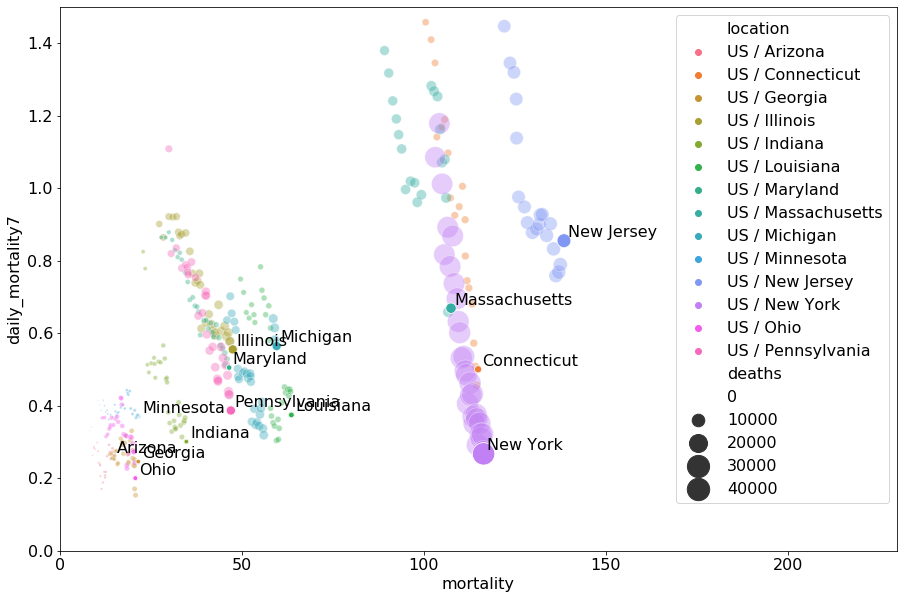

In [85]:
world_hit = ds_states.sel(location=(((ds_states['daily_mortality7'].isel(time=-1) > .2) & (ds_states['mortality'] > 0).any('time')) & (ds_states['deaths'] > 1_000)).any('time')).isel(time=slice(-30, None)).to_dataframe().reset_index()
ax = sns.scatterplot(x="mortality", y="daily_mortality7", hue="location", size="deaths", data=world_hit, alpha=0.4, sizes=(0, 500))
ax = sns.scatterplot(x="mortality", y="daily_mortality7", hue="location", size="deaths", data=world_hit[world_hit['time']==world_hit['time'].max()], sizes=(0, 500), legend=False)
_ = ax.set(ylim=(0, 1.5), xlim=(0, 230))
for index in world_hit[world_hit['time']==world_hit['time'].max()].index:
    record = world_hit.loc[index]
    ax.annotate(record['location'].partition('US / ')[2], (record['mortality'] + 1, record['daily_mortality7'] + .01))

In [35]:
#### DAY = np.timedelta64(24 * 60 * 60, 's')
PALETTE_ONE = list(sns.color_palette())


EXTENT = ('2020-03-01', '2020-06-10')
XLIM = tuple(map(np.datetime64, EXTENT))

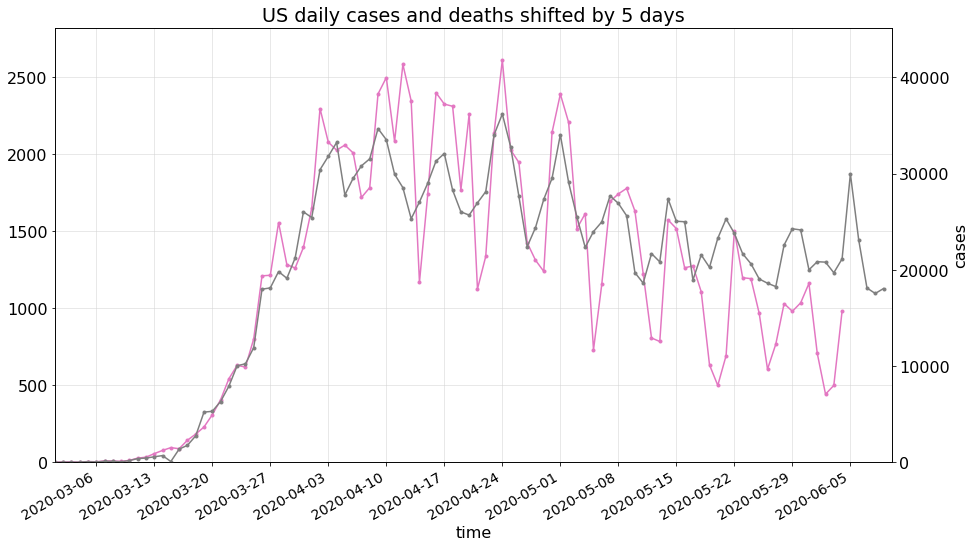

In [36]:
_, ax1 = covid19.plot.subplots(subplot_kw={'xlim': XLIM})
ax1.set_title(f'COVID-19 USA - Linear scale')
ax2 = ax1.twinx()

usa = ds_states.sum('location')

covid19.plot.plot_data(ax1, usa['daily_deaths'].rolling({'time': 1}).mean(), delay=-5)
covid19.plot.plot_data(ax2, usa['daily_confirmed'].rolling({'time': 1}).mean())

ax1.set(ylim=(0, usa['population'] / 120_000), title='US daily cases and deaths shifted by 5 days') 
_ = ax2.set(ylim=(0, usa['population'] / 7_500), ylabel='cases') 



In [37]:
STATES_FIT_PARAMS = {
    'US / New York': {
        'deaths': ['2020-03-22', '2020-04-04'],
    },
    'US / New Jersey': {
        'deaths': [None, '2020-04-05', '2020-04-05'],
    },
    'US / Connecticut': {
        'deaths': [None, '2020-04-08'],
    },
    'US / Massachusetts': {
        'deaths': [None, '2020-04-07'],
    },
    'US / Louisiana': {
        'deaths': [None, '2020-04-01'],
    },
    'US / District of Columbia': {
        'deaths': [None, '2020-04-01'],
    },
    'US / Michigan': {
        'deaths': ['2020-03-25', '2020-04-02', None],
    },
    'US / Rhode Island': {
        'deaths': [None, '2020-04-08'],
    },
    'US / Pennsylvania': {
        'deaths': [None, '2020-04-08'],
    },
    'US / Maryland': {
        'deaths': [None, None],
    },
    'US / Illinois': {
        'deaths': [None, '2020-04-10'],
    },
    'US / Indiana': {
        'deaths': [None, '2020-04-08'],
    },
    'US / Colorado': {
        'deaths': [None, None],
    },
    'US / Washington': {
        'deaths': [None, '2020-03-26', '2020-04-10'],
    },
    'US / Georgia': {
        'deaths': [None, '2020-04-10'],
    },
    'US / California': {
        'deaths': [None, '2020-03-26', None],
    },
    'US / Florida': {
        'deaths': [None, None],
    },
    'US / Delaware': {
        'deaths': [None, None],
    },
    'US / Nebraska': {
        'deaths': [None, None],
    },
}

In [38]:
region_fits = {}
for region, params in list(STATES_FIT_PARAMS.items()):
    region_fits[region] = {}
    for kind, breaks in params.items():
        ds = ds_states.sel(location=region)
        region_fits[region][kind] = covid19.fit.fit_exponential_segments(ds[kind], breaks)
        if 'daily_' + kind in ds:
            kinf = 'daily_' + kind 
            region_fits[region][kind] = covid19.fit.fit_exponential_segments(ds[kind], breaks)


ImportError: Plotting of arrays of cftime.datetime objects or arrays indexed by cftime.datetime objects requires the optional `nc-time-axis` (v1.2.0 or later) package.

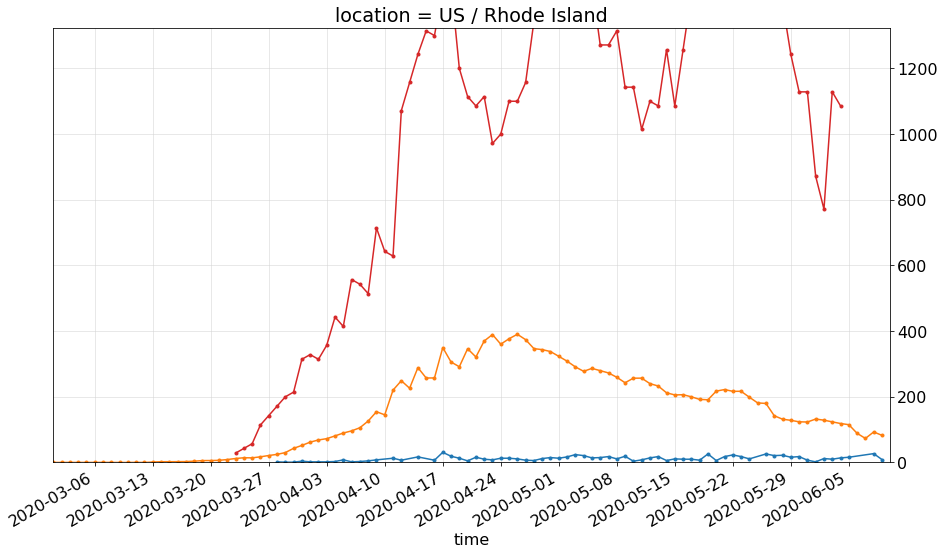

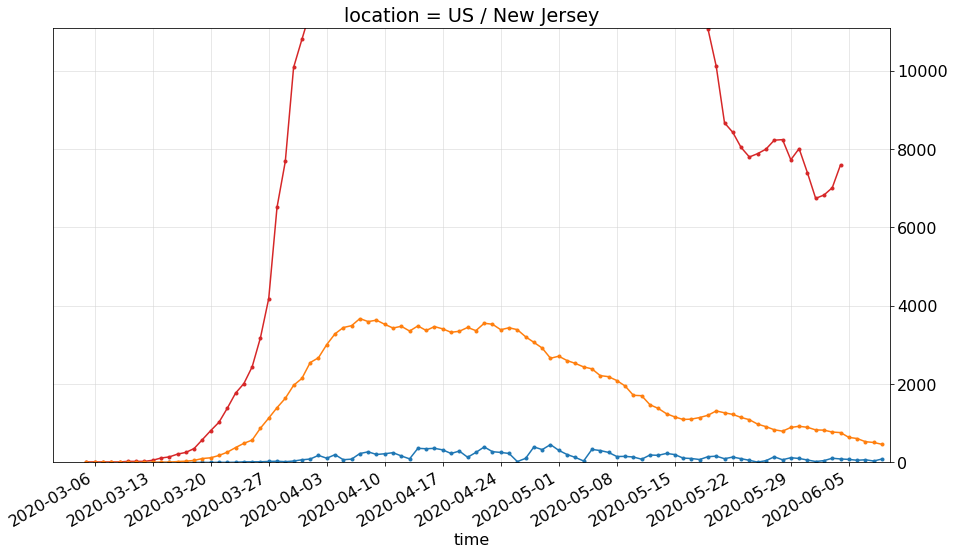

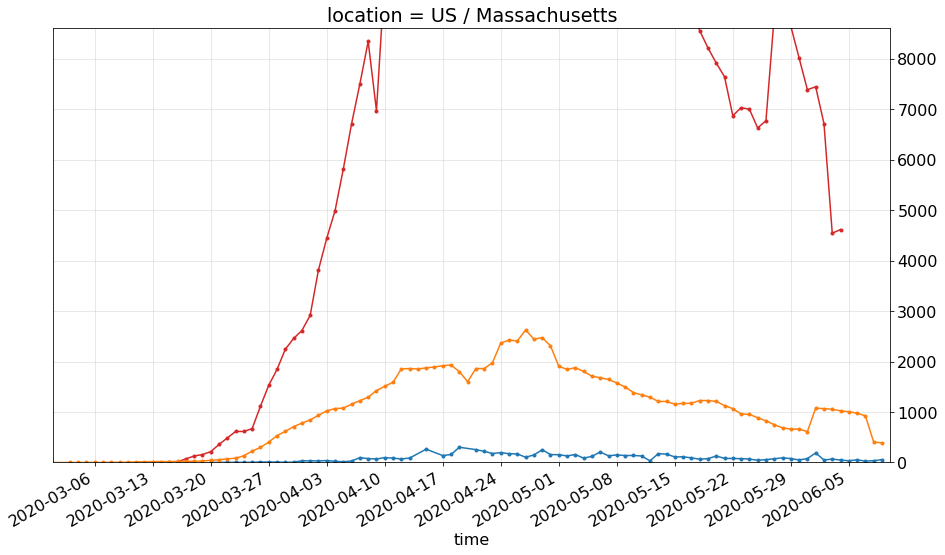

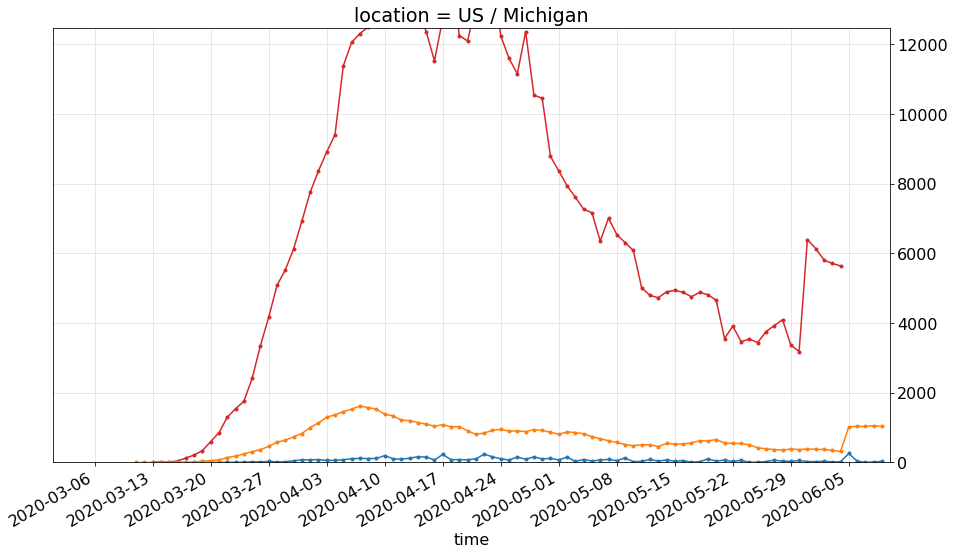

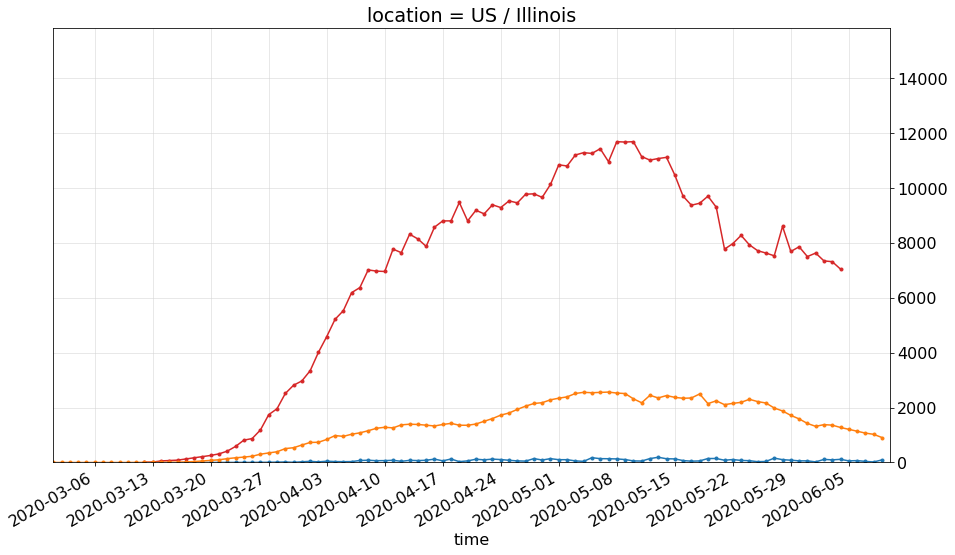

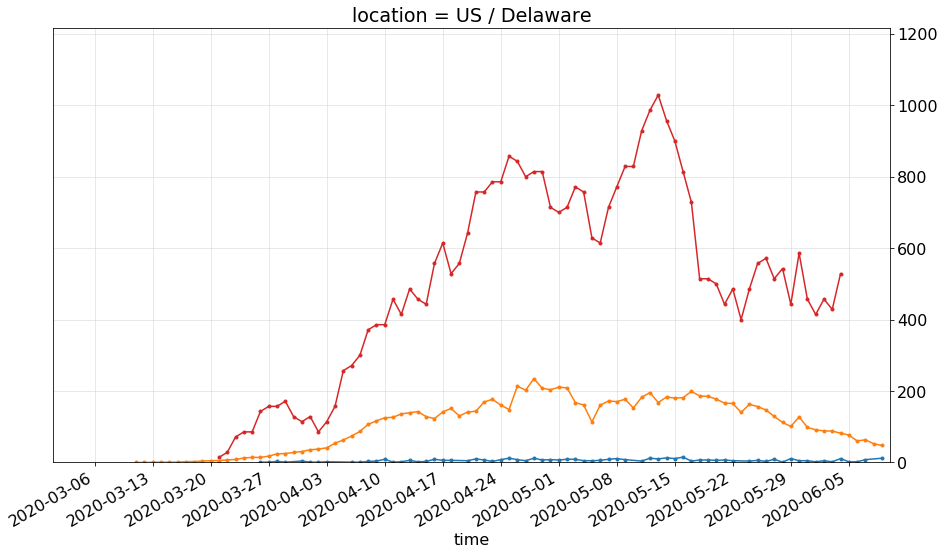

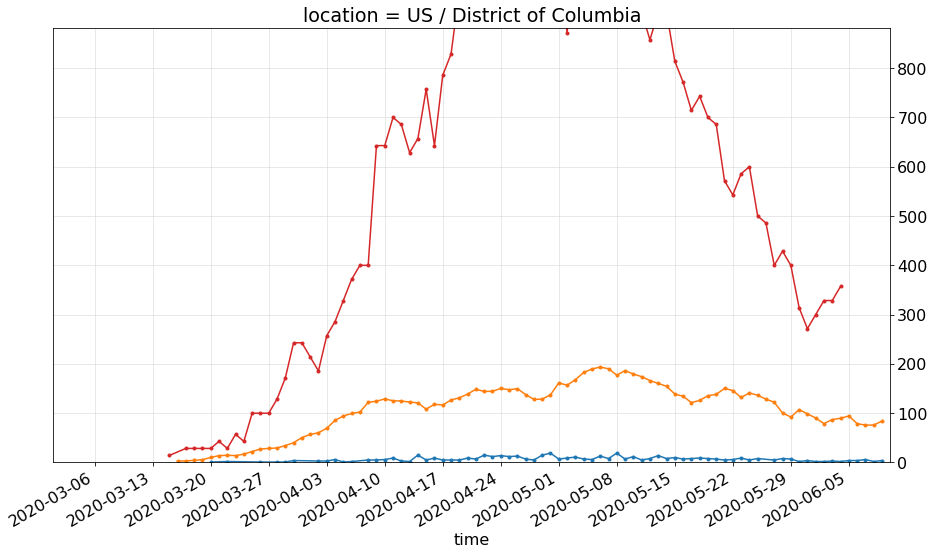

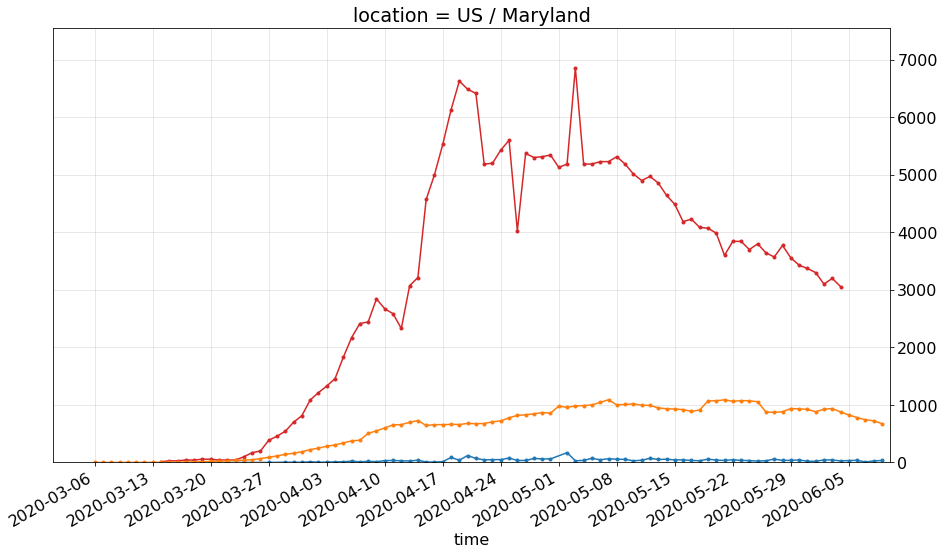

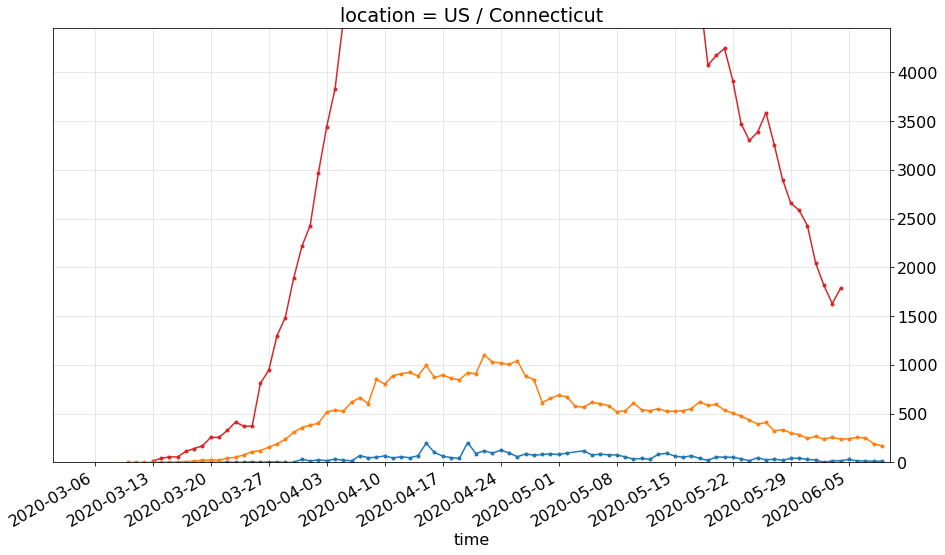

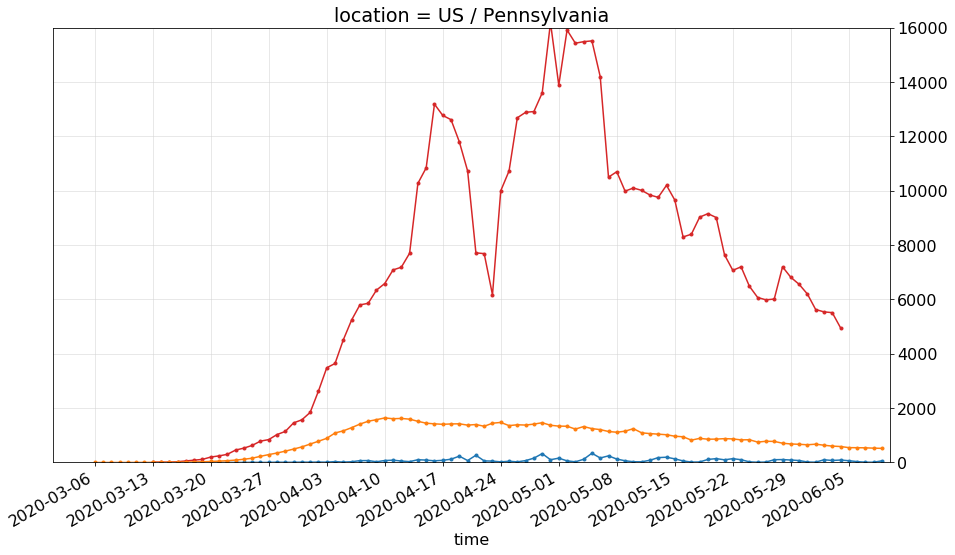

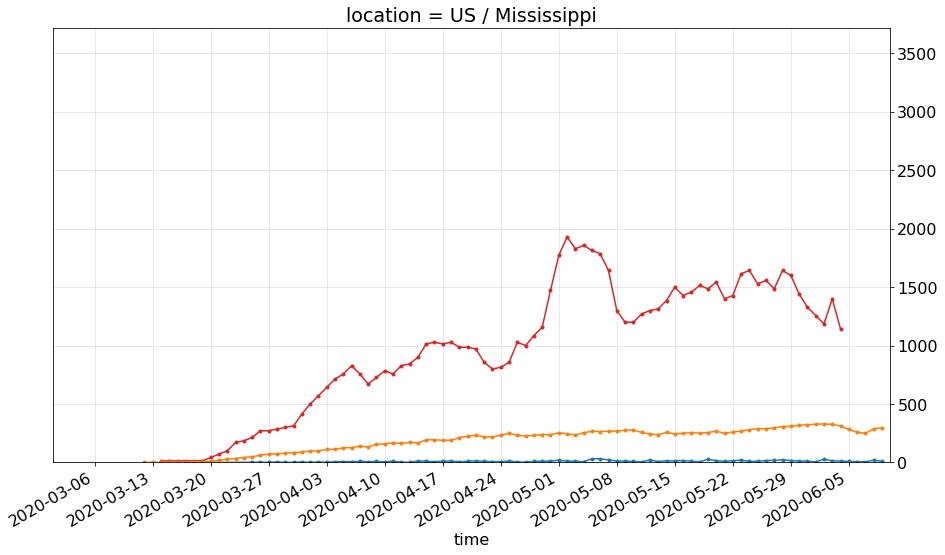

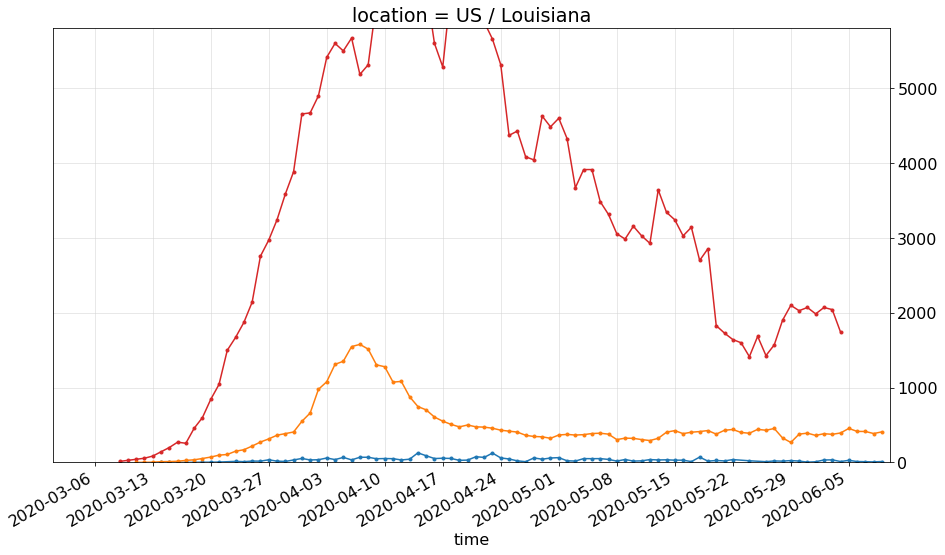

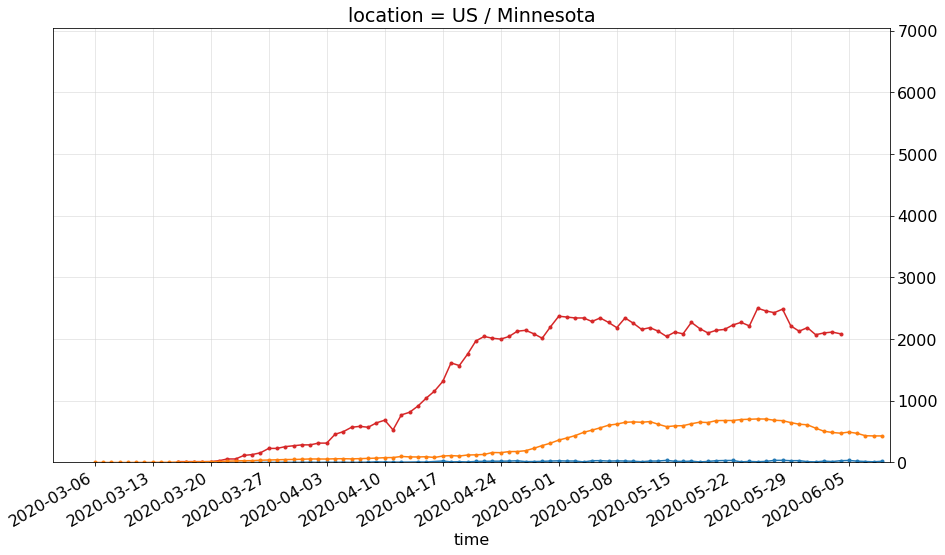

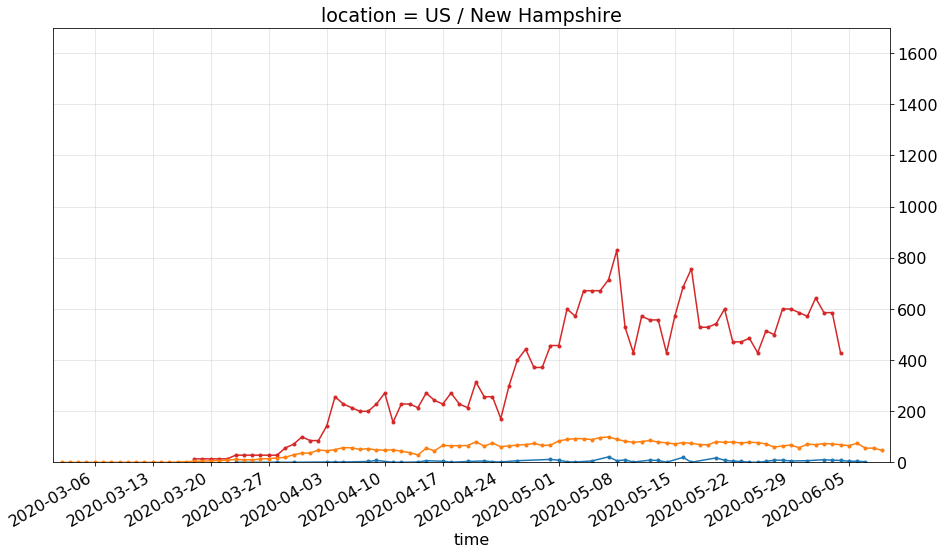

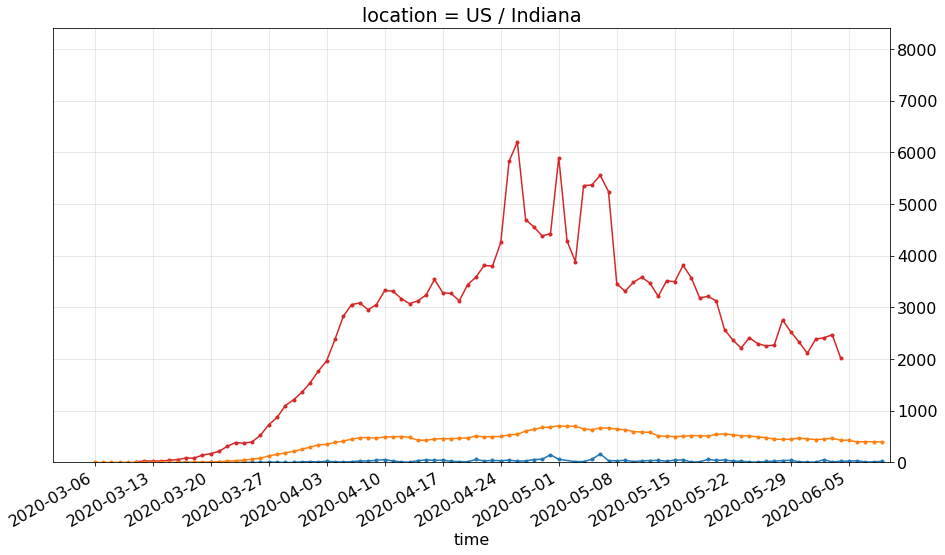

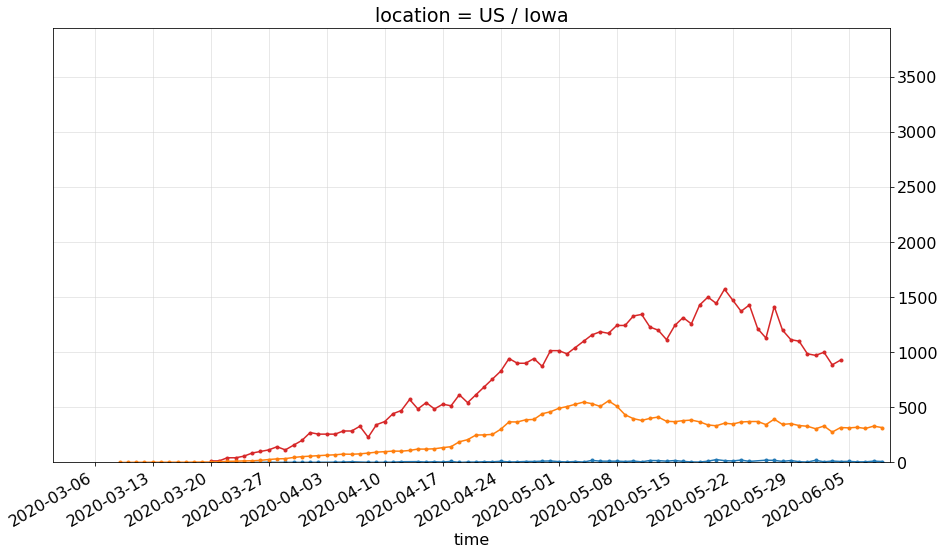

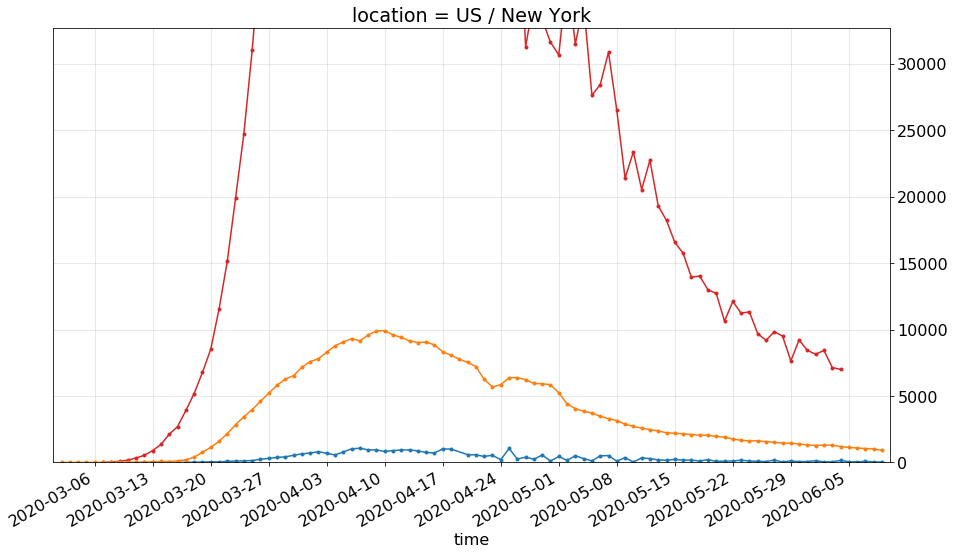

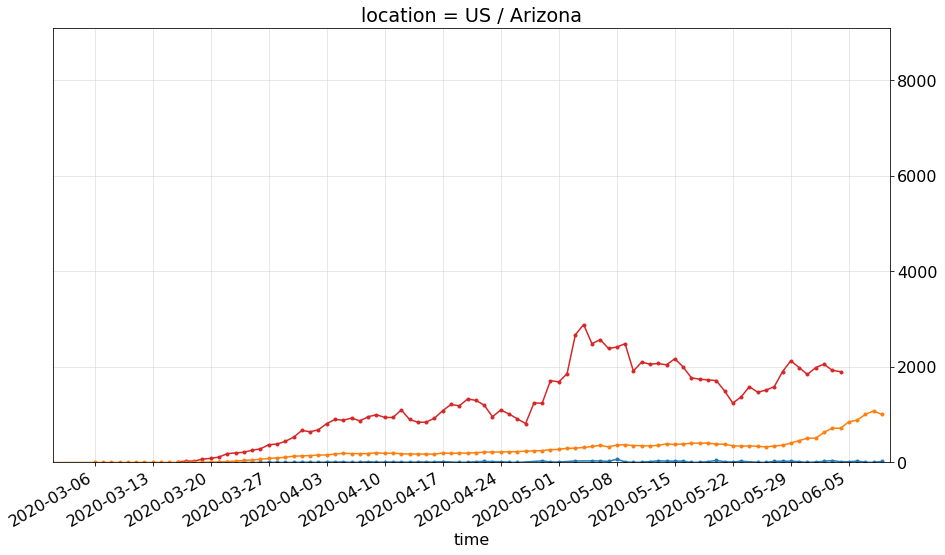

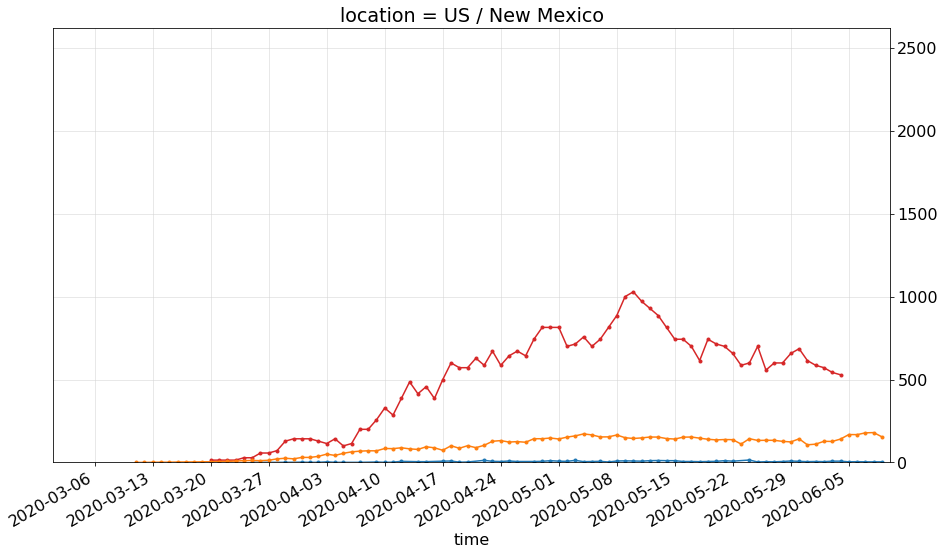

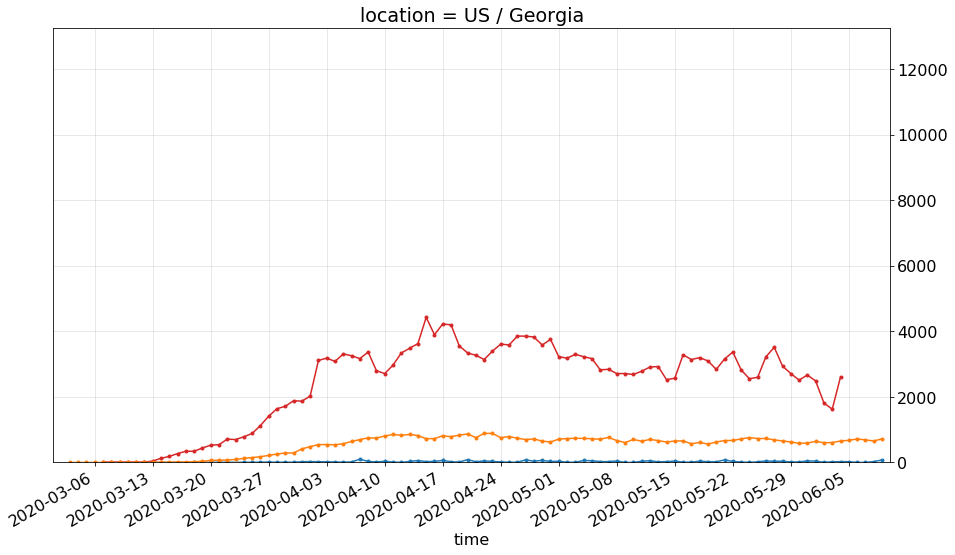

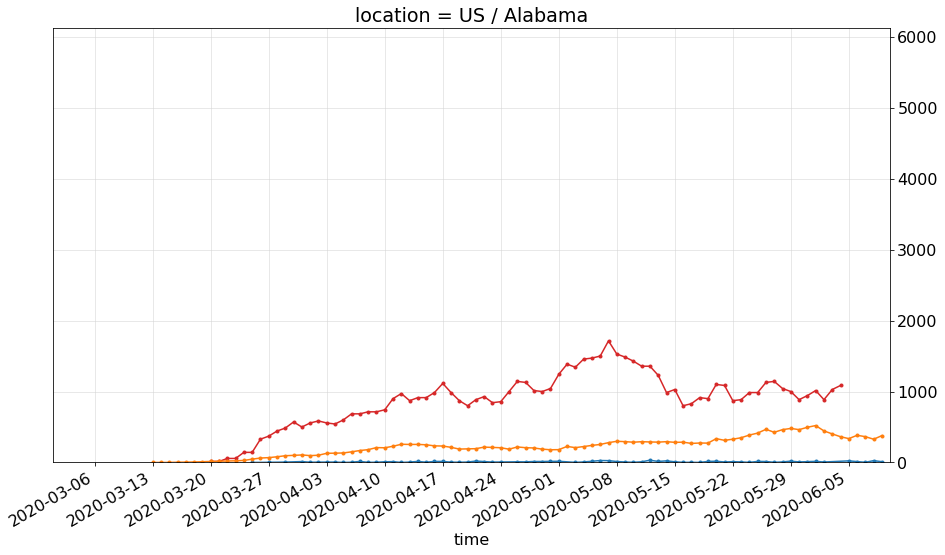

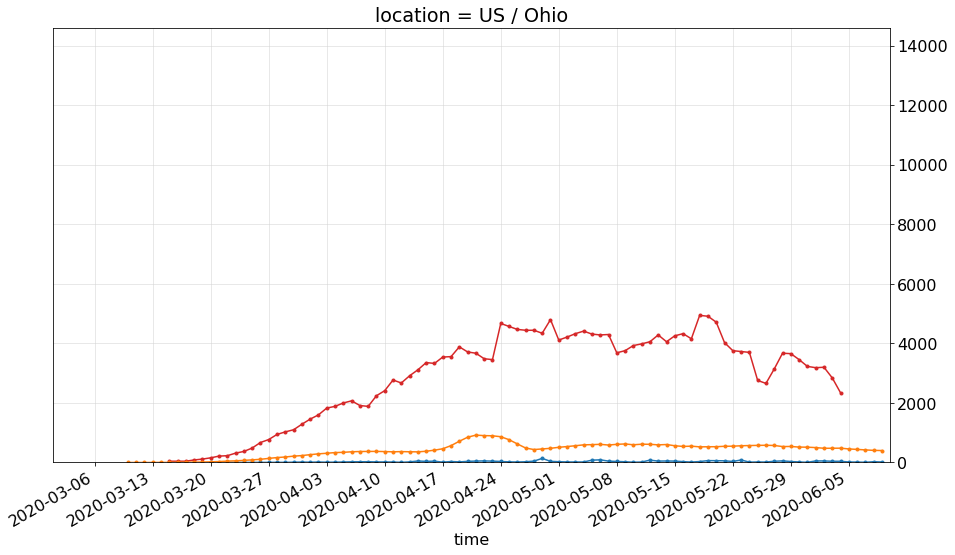

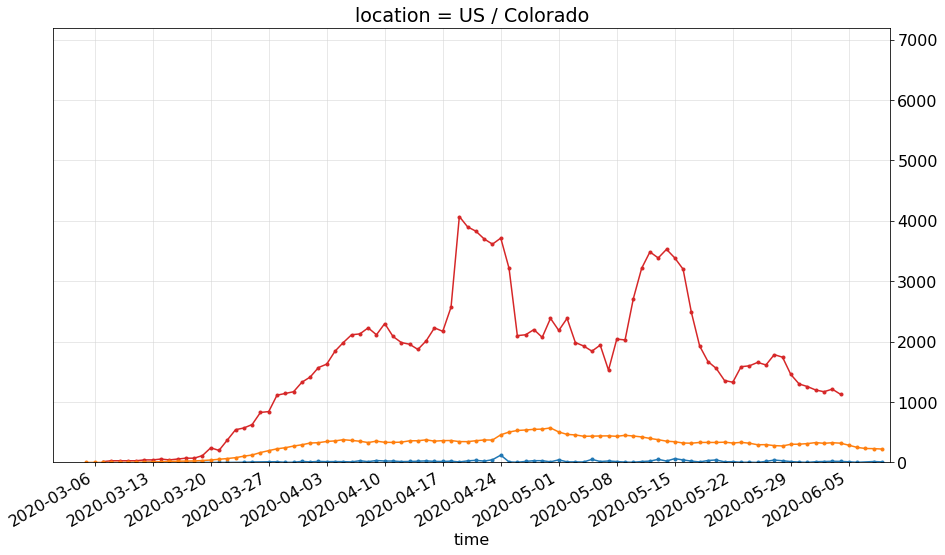

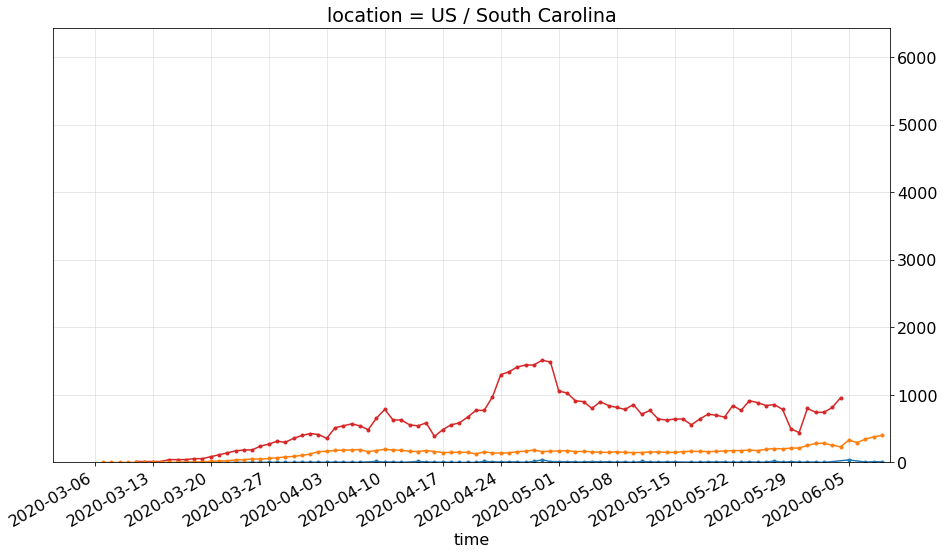

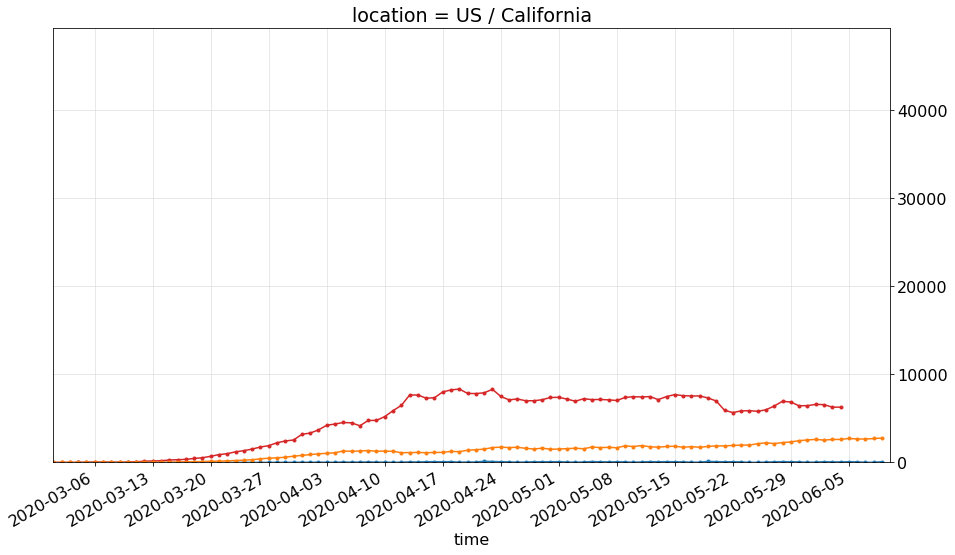

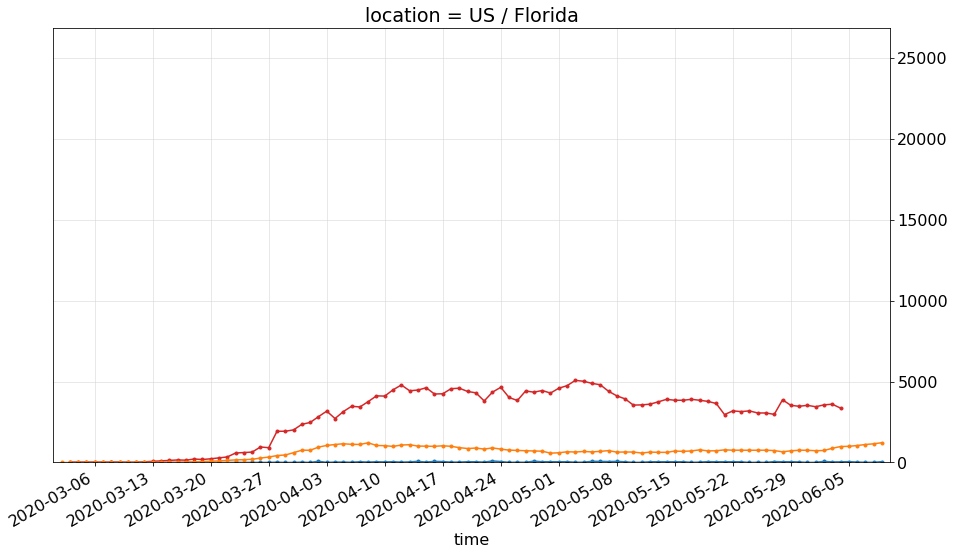

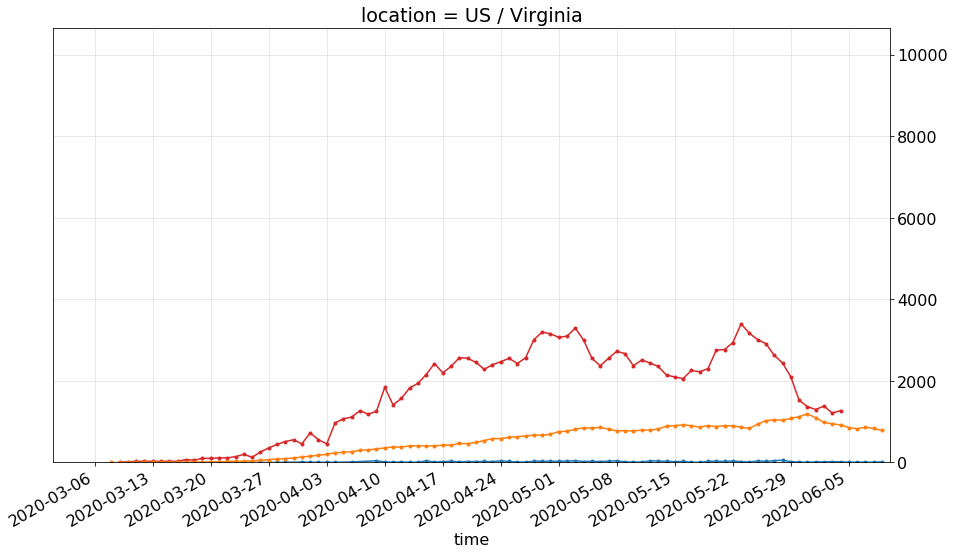

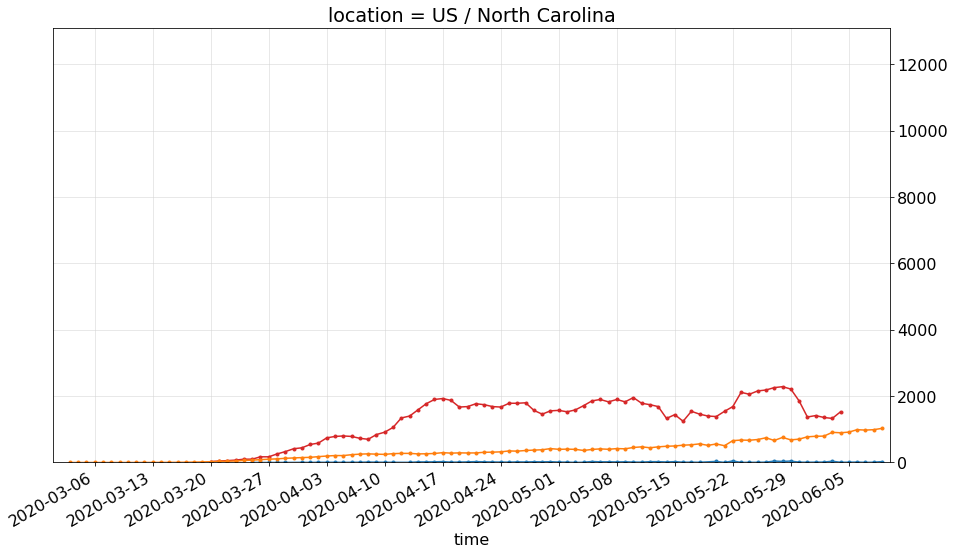

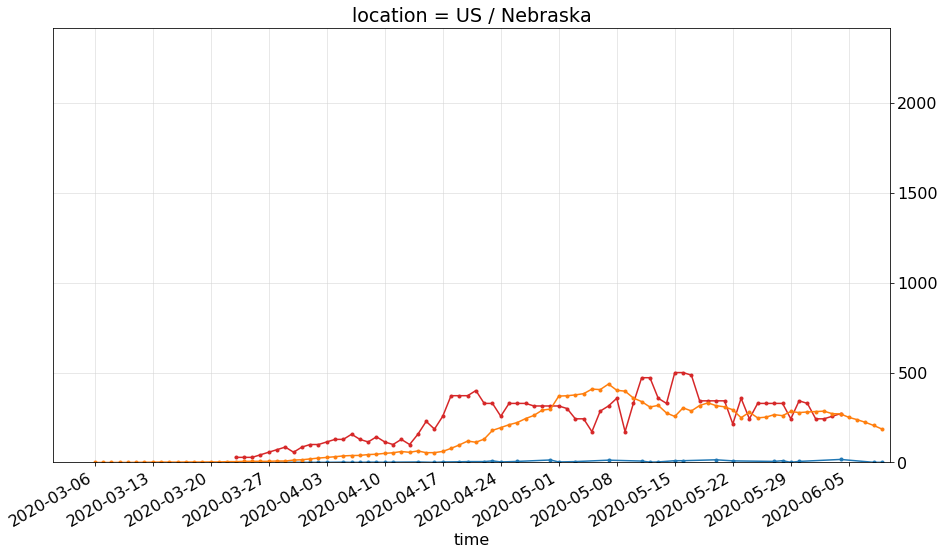

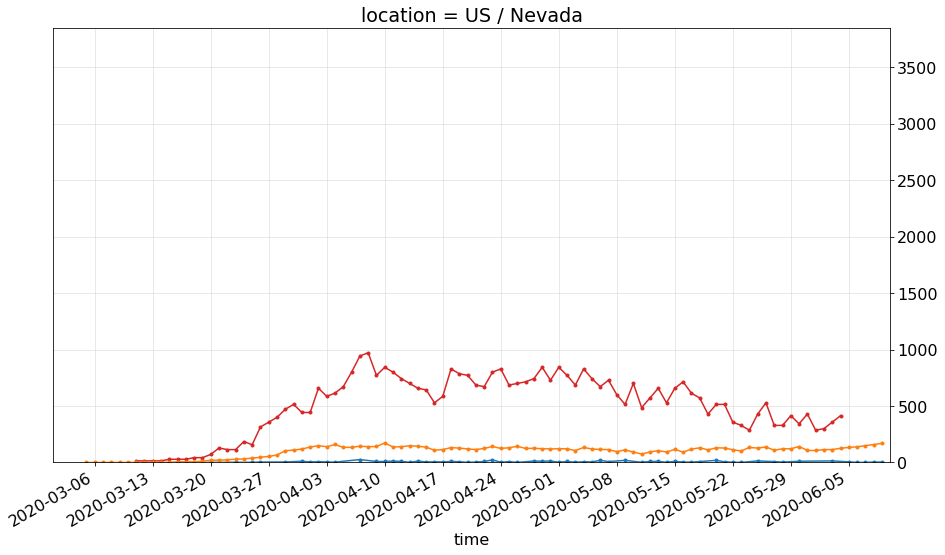

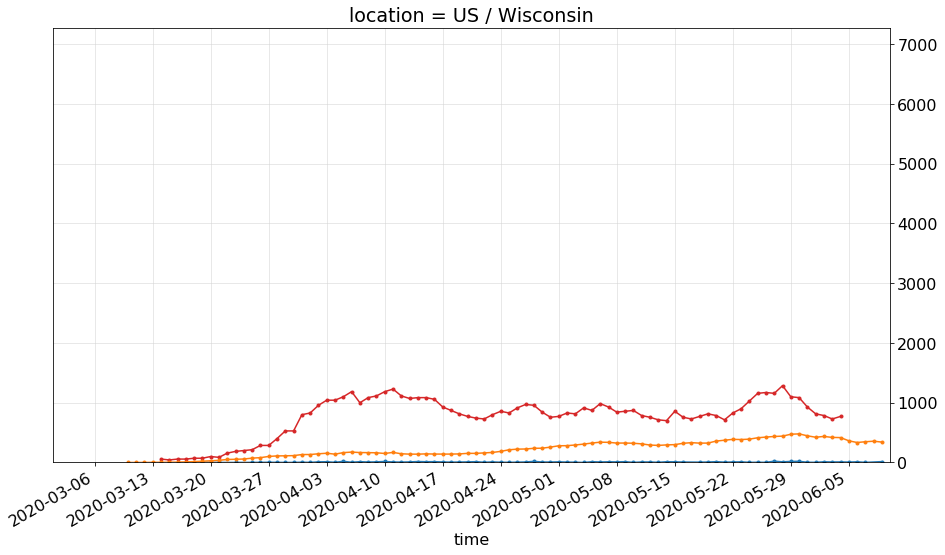

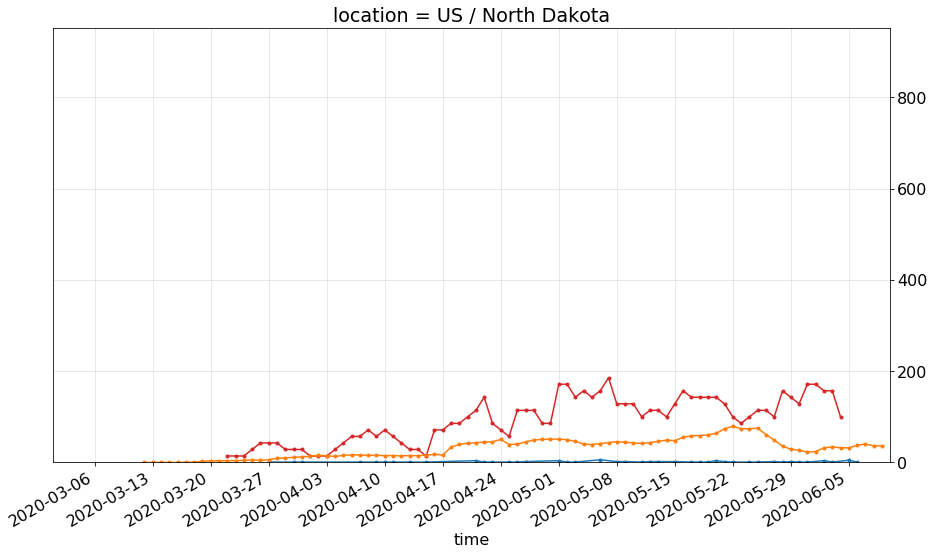

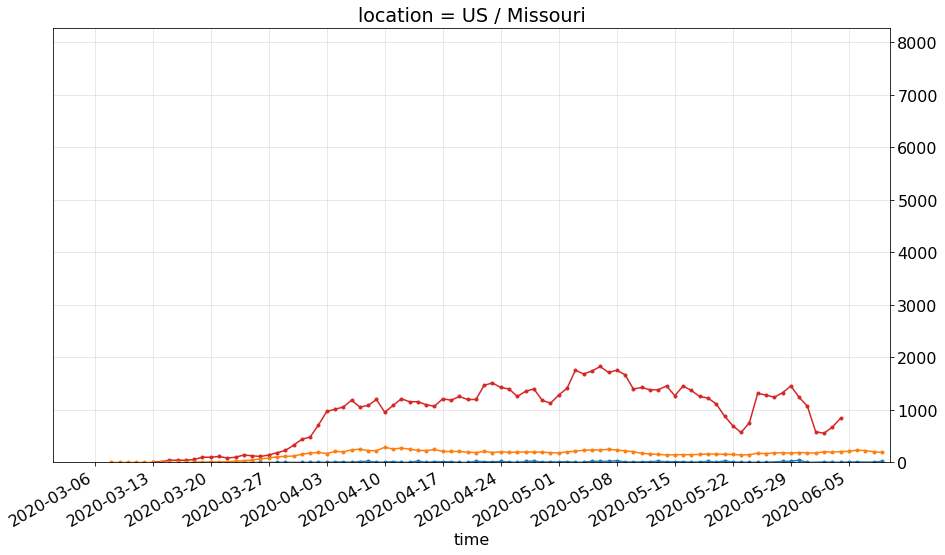

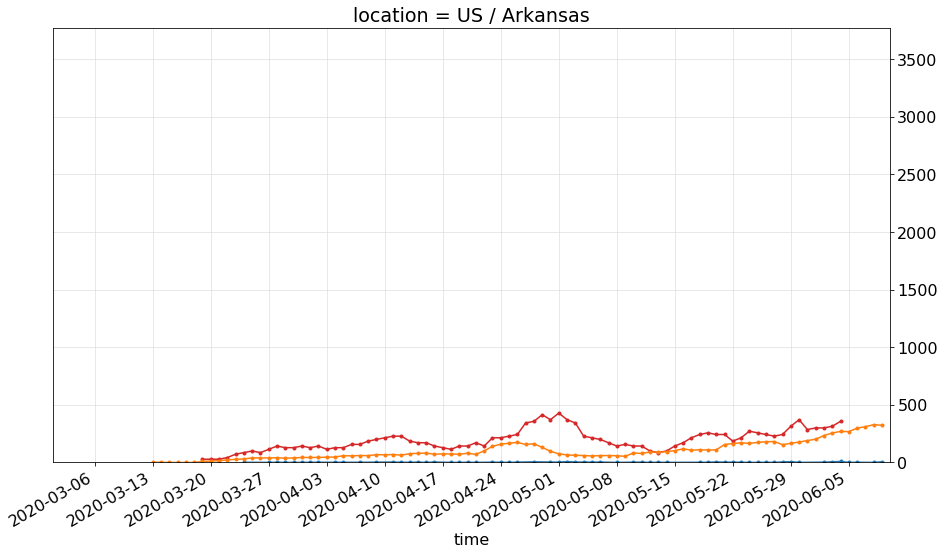

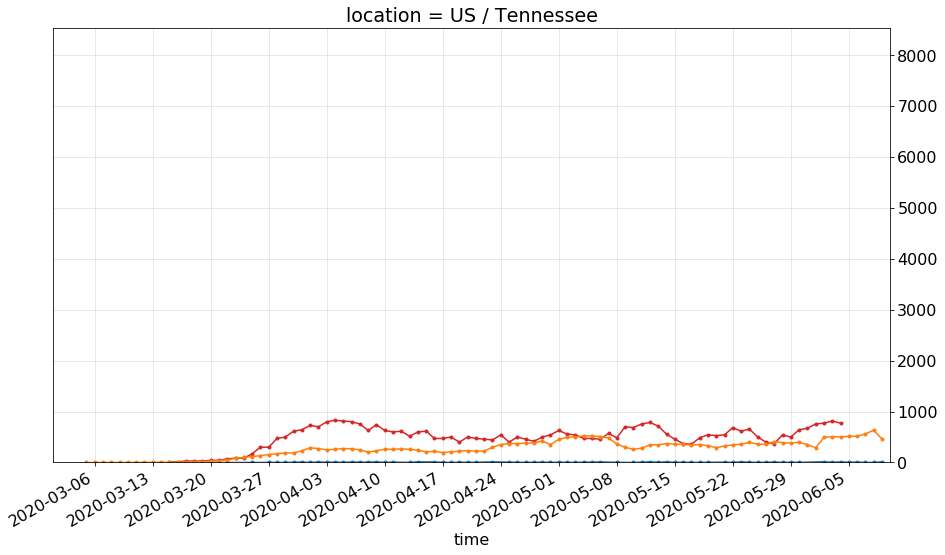

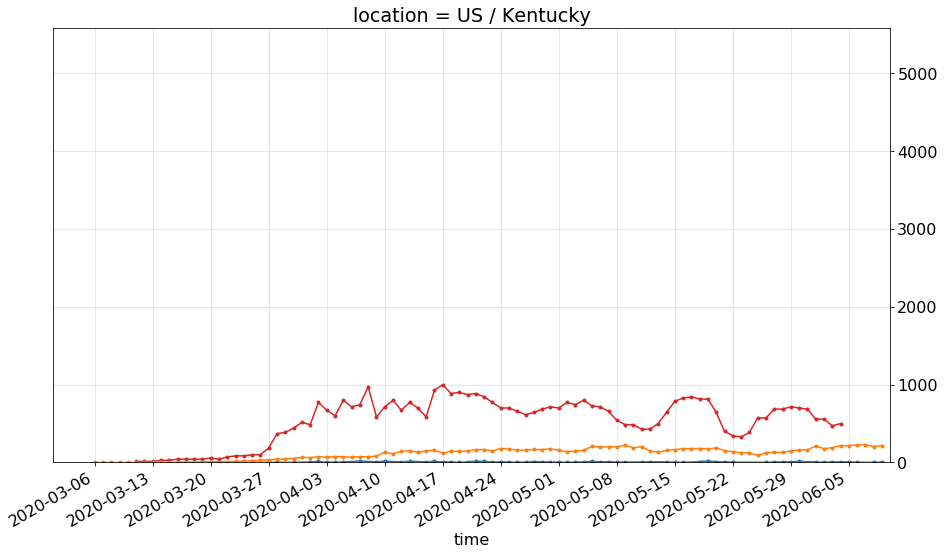

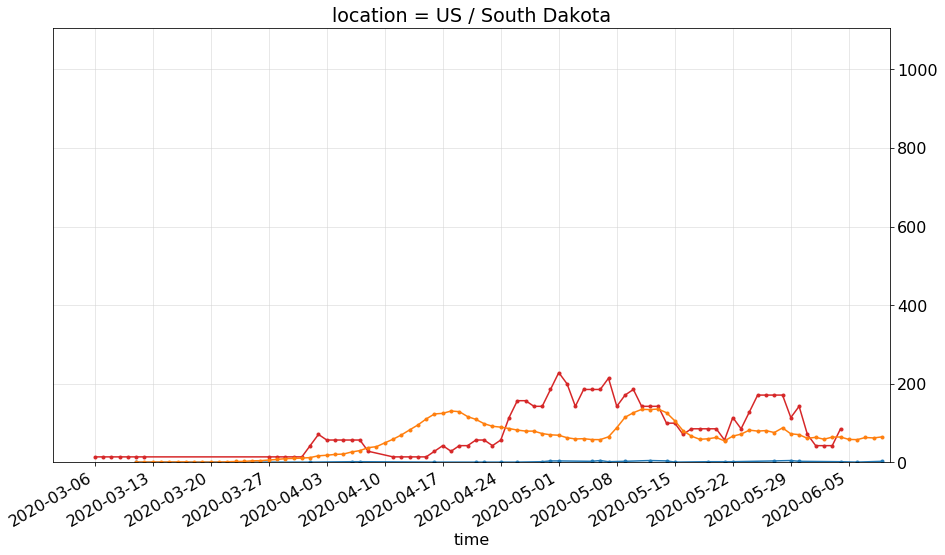

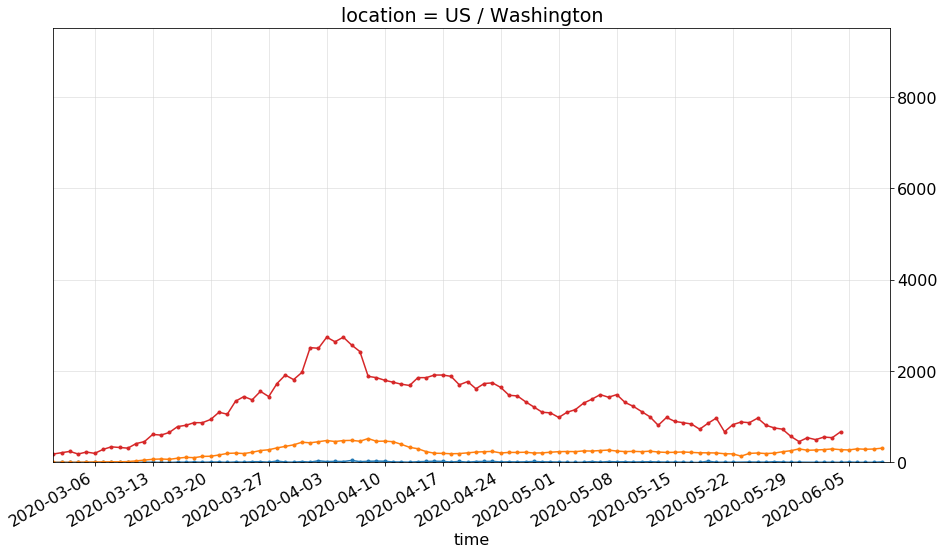

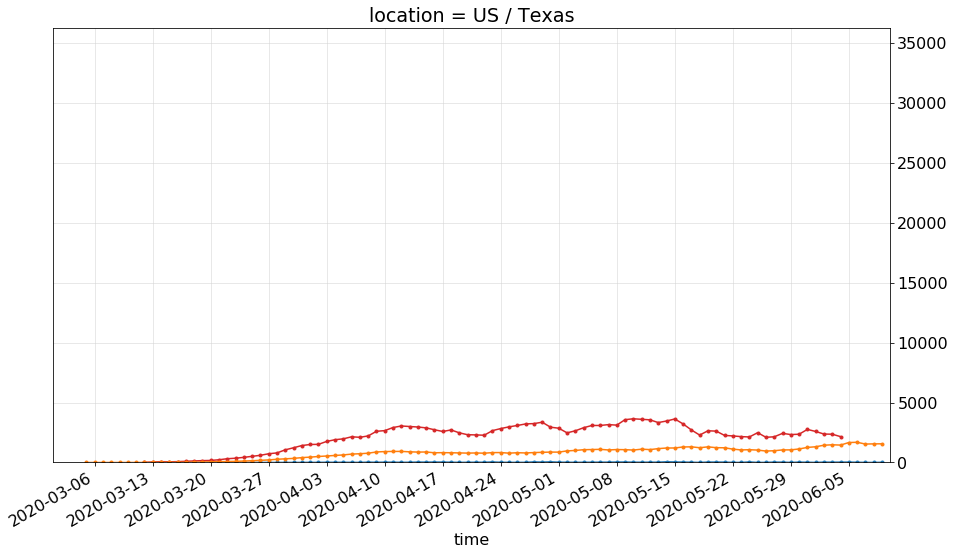

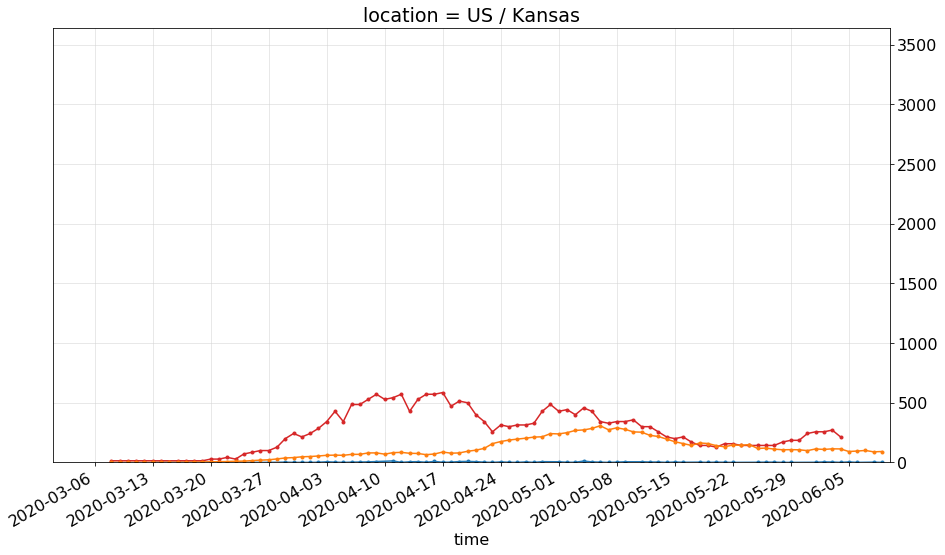

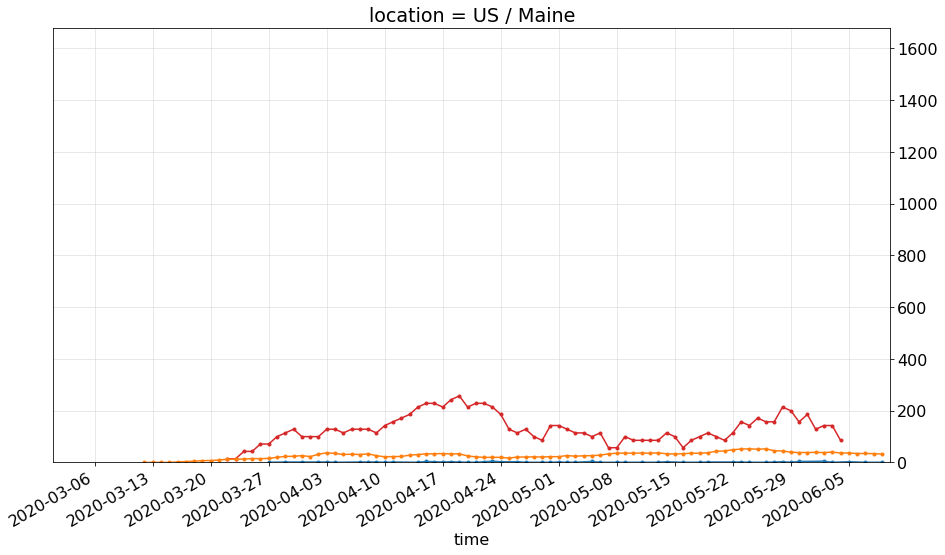

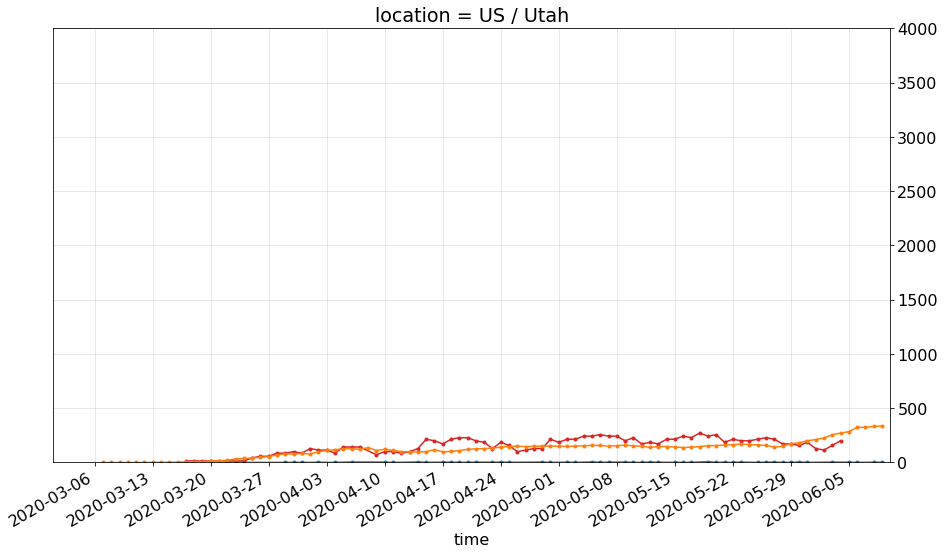

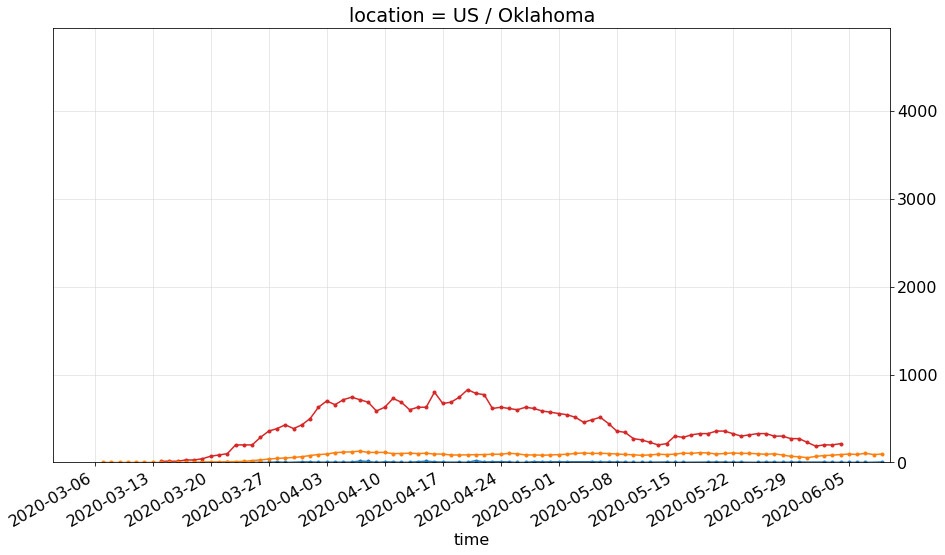

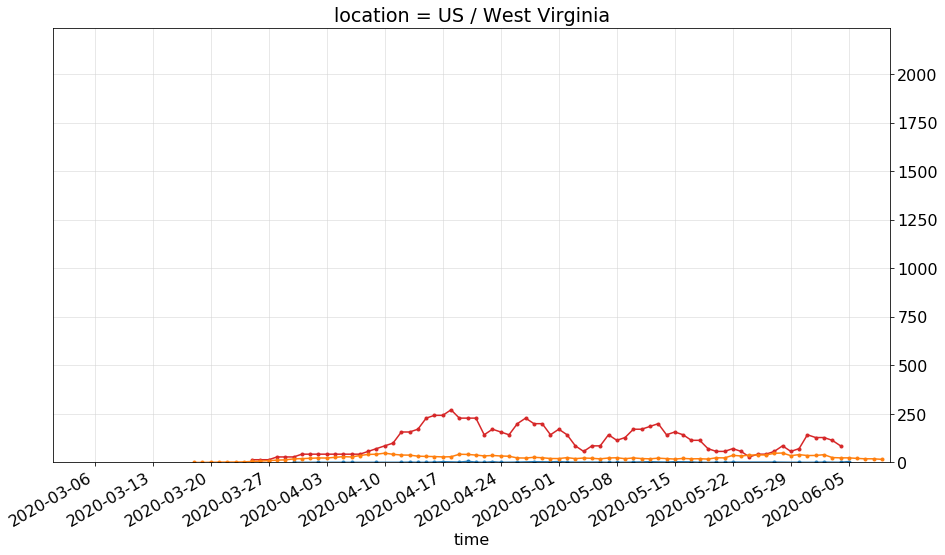

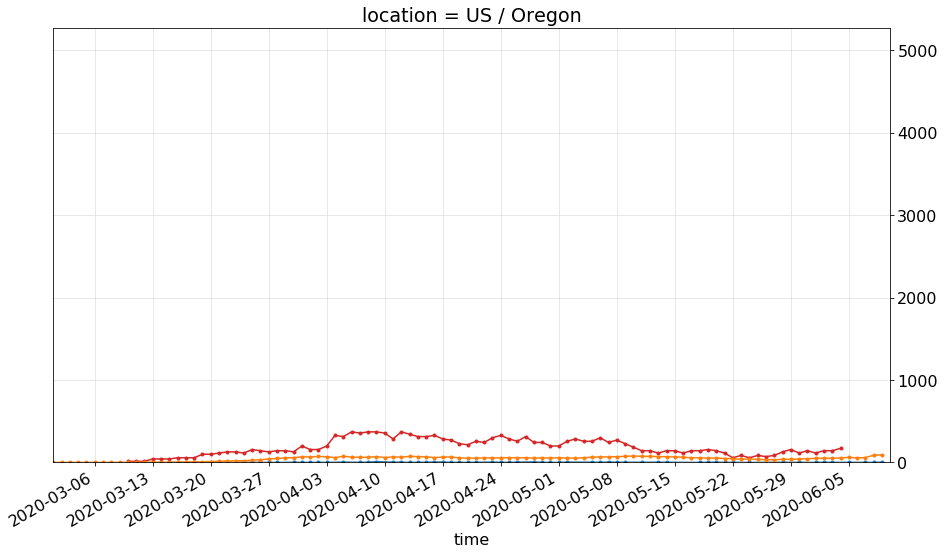

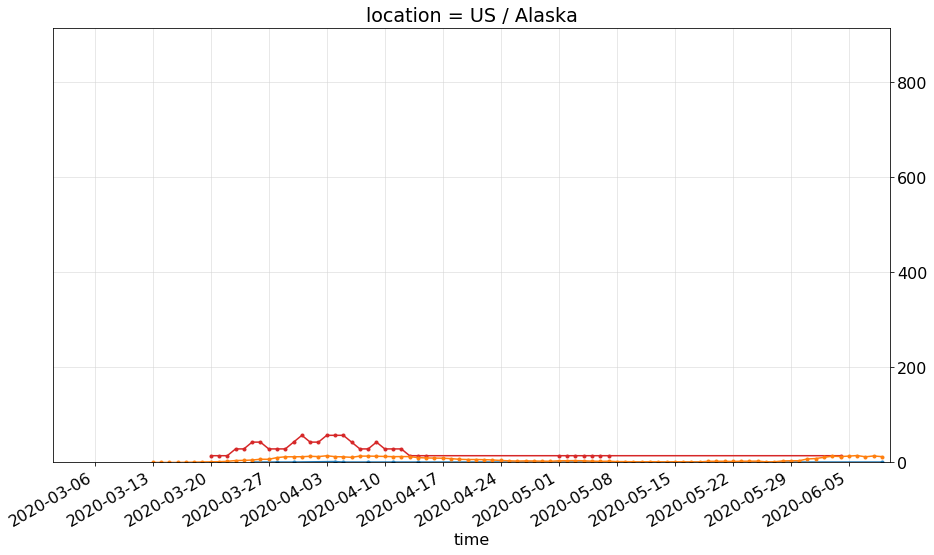

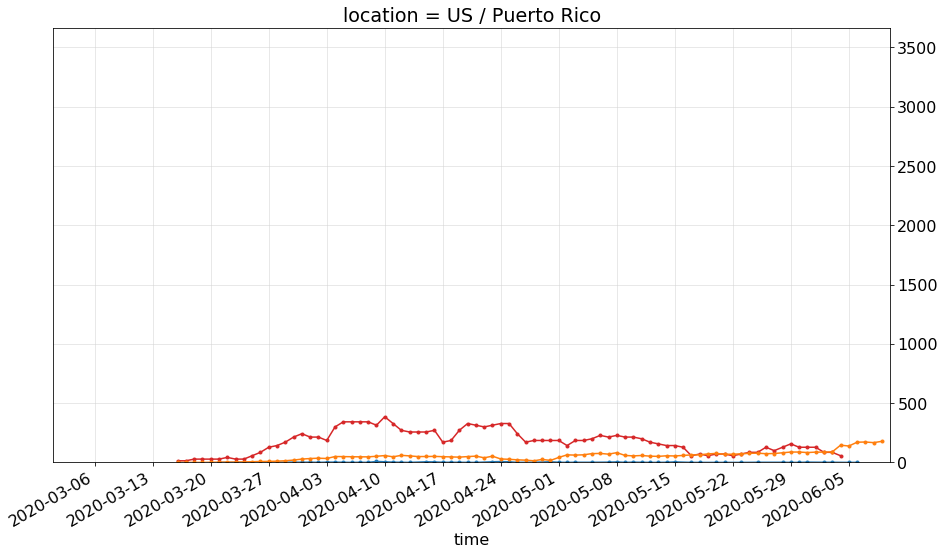

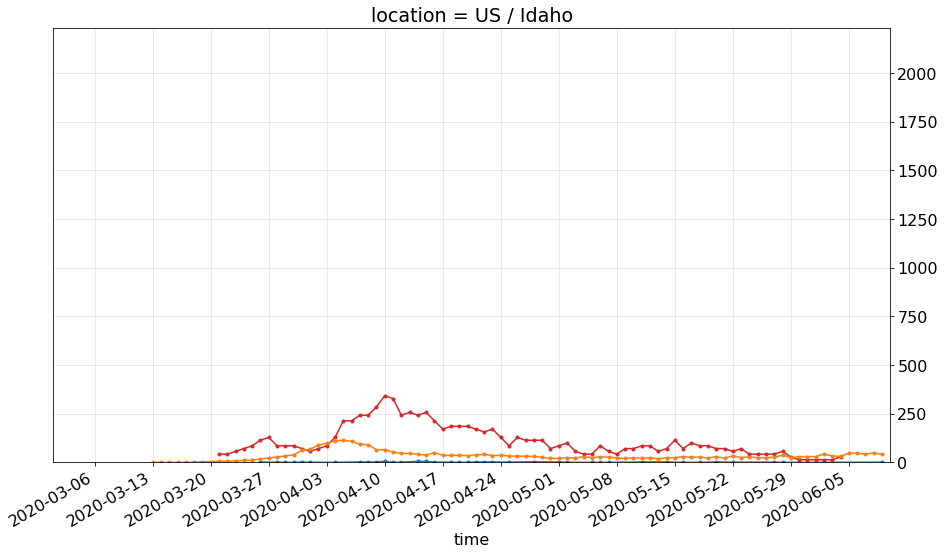

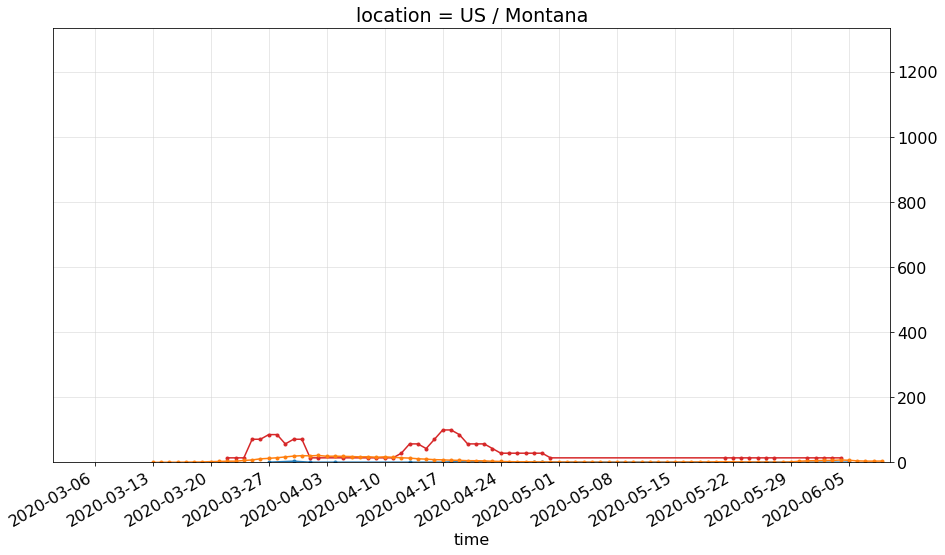

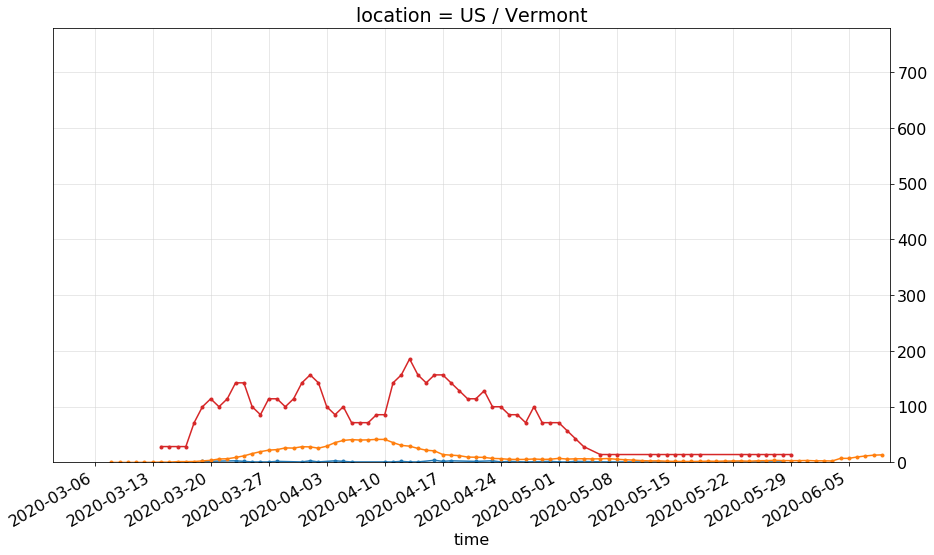

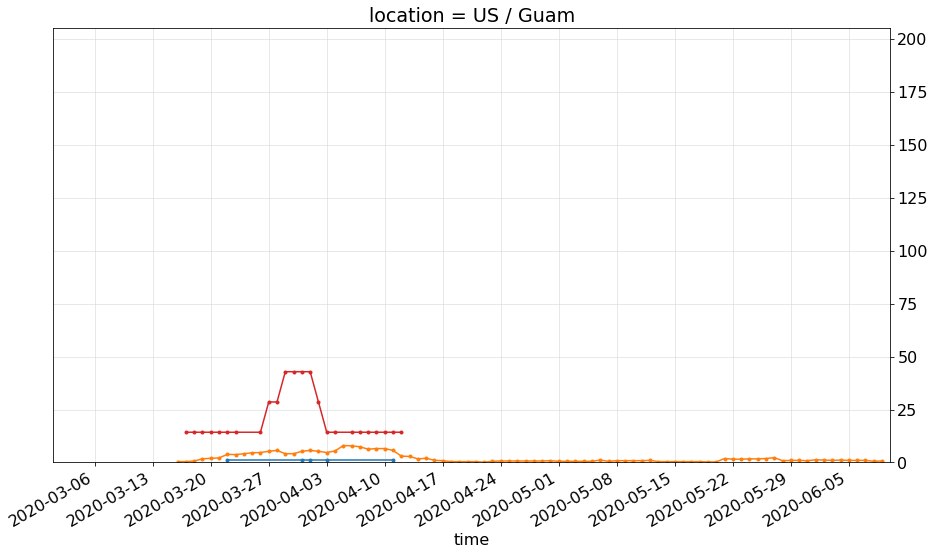

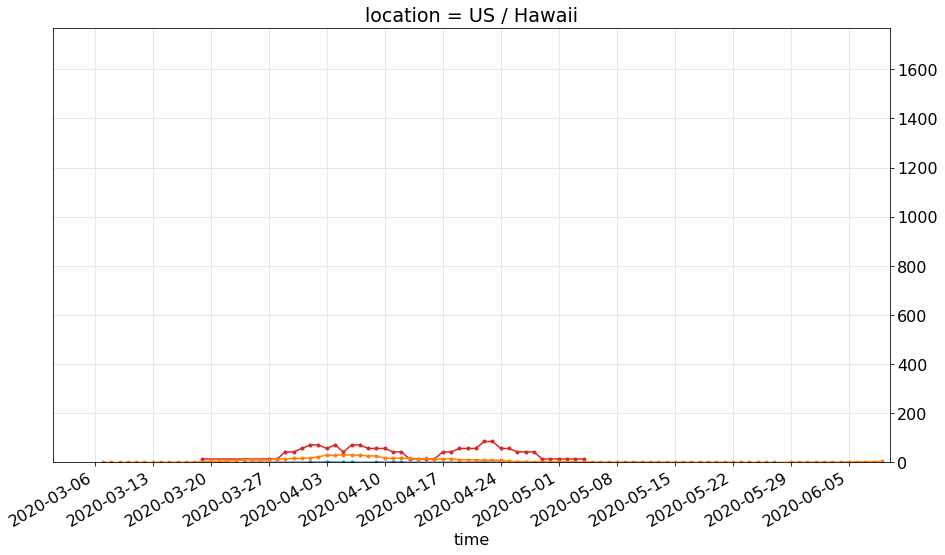

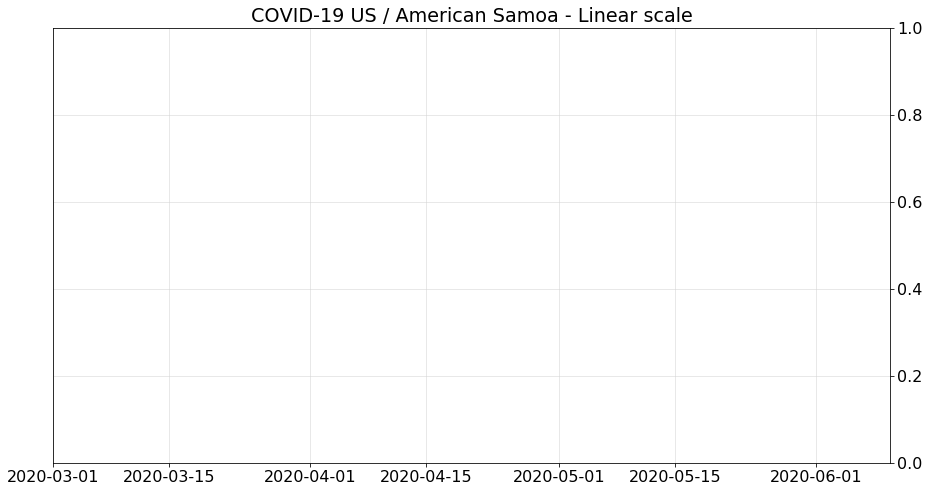

In [42]:

for region in STATES:
    fit_kinds = {'deaths': []}
#    _, ax0 = plt.subplots(subplot_kw={'xlim': XLIM})
    _, ax1 = plt.subplots(subplot_kw={'xlim': XLIM})

#    ax0.set(yscale='log', ylim=(ds_states['population'].max().values / 5000000, ds_states['population'].max().values / 500)) 
#    ax0.set_title(f'COVID-19 {region} - Log scale')
#    ax0.yaxis.tick_right()
#    ax0.yaxis.grid(color='lightgrey', linewidth=0.5)
#    ax0.xaxis.grid(color='lightgrey', linewidth=0.5)

    ax1.set_title(f'COVID-19 {region} - Linear scale')
    ax1.yaxis.tick_right()
    ax1.yaxis.grid(color='lightgrey', linewidth=0.5)
    ax1.xaxis.grid(color='lightgrey', linewidth=0.5)

    ds = ds_states.sel(location=region)

    for (kind, fits), color in zip(fit_kinds.items(), PALETTE_ONE):
        if kind.startswith('daily_'):
            continue
#        covid19.plot.plot_data(ax0, ds[kind], color=color)
#        covid19.plot.plot_data(ax0, ds[kind] * 100, delay=-5, color=PALETTE_ONE[3])
        covid19.plot.plot_data(ax1, ds['daily_' + kind].rolling({'time': 1}).mean(), color=color)
        covid19.plot.plot_data(ax1, ds['daily_' + kind].rolling({'time': 7}).mean() * 100, delay=-5, color=PALETTE_ONE[3])
        # covid19.plot.plot(ax1, data[region][kind], fit, label=kind, color=color, date_interval=5, add_diff=False)
    kind = 'confirmed'
#    covid19.plot.plot_data(ax0, ds[kind], color=PALETTE_ONE[1])
    covid19.plot.plot_data(ax1, (ds['daily_' + kind]).rolling({'time': 7}).mean(), color=PALETTE_ONE[1])
    
    ax1.set(ylim=(0, ds['population'] / 800)) 
